In [159]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import math 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from nonlincausality.nonlincausality import nonlincausalityARIMA, nonlincausalityMLP
from numpy import log
from statsmodels.tsa.arima_model import ARIMA
from causal_ccm.causal_ccm import ccm
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from pandas import read_csv
import multiprocessing as mp
import os 
import sys 
sys.path.append(os.getcwd())
sys.path.append('/home/priyam/projects/predator-prey')
### Just to remove warnings to prettify the notebook. 
import warnings
warnings.filterwarnings("ignore")
from environments.discrete_pp_v1 import ChaserAgent, FixedSwingAgent, FollowerAgent
from environments.wolfpack_discrete import wolfpack_discrete

CAUSAL_PAIRS = [("predator_0", "predator_1"), ("predator_1", "predator_0")]

In [169]:
def play_episode(env, policy_mapping_fn, is_recurrent):
    explore = False
    if explore:
        warnings.warn("Exploration is on!")
    # create a data frame to store the data for
    # agents A and agent B

    step = 0
    obs, info = env.reset()
    center = env.state().shape[0] // 2
    done = False
    if is_recurrent:
        rnn_states = dict()
        last_actions = dict()
        last_rewards = dict()
        for agent_id in env.agents:
            last_actions[agent_id] = 0
            last_rewards[agent_id] = 0
            rnn_states[agent_id] = policy_mapping_fn[agent_id].get_initial_state()
    else:
        rnn_states = None
        last_actions = None
        last_rewards = None

    while env.agents:
        actions = dict()
        for agent_id in env.agents:
            if is_recurrent:
                actions[agent_id], rnn_states[agent_id], _ = policy_mapping_fn[
                    agent_id
                ].compute_single_action(
                    obs[agent_id], state=rnn_states[agent_id], explore=explore,
                    prev_action=last_actions[agent_id], prev_reward=last_rewards[agent_id]
                )
            else:
                actions[agent_id] = policy_mapping_fn[agent_id].compute_single_action(
                    obs[agent_id], explore=explore
                )[0]

        obs, rewards, terminated, truncated, infos = env.step(actions)
        step += 1
        if is_recurrent:
            last_actions = actions
            last_rewards = rewards
    
    return env._game_history[:env._game_step - 1]


def transform_epsiode_history(agents, episode_history):
    col_list = ["x", "y", "action", "dx", "dy", "PCA_1", "PCA_2"]
    selected_data = None  
    for agent_id in agents:
        episode_history[f'{agent_id}_x'] =\
              episode_history[f'{agent_id}_position'].apply(eval).apply(lambda x: x[0]).astype(int)
        episode_history[f'{agent_id}_y'] =\
              episode_history[f'{agent_id}_position'].apply(eval).apply(lambda x: x[1]).astype(int)
        episode_history[f'{agent_id}_dx'] =\
              episode_history[f'{agent_id}_x'].diff(-1).fillna(0)
        episode_history[f'{agent_id}_dy'] =\
              episode_history[f'{agent_id}_y'].diff(-1).fillna(0)
        
        xy_data = episode_history.loc[:, [f"{agent_id}_x", f"{agent_id}_y"]].to_numpy()
        episode_history[f'{agent_id}_PCA_1'] = (
            PCA(n_components=1).fit_transform(xy_data).flatten()
        )

        xy_data = episode_history.loc[:, [f"{agent_id}_x", f"{agent_id}_y", f"{agent_id}_action"]].to_numpy()
        episode_history[f'{agent_id}_PCA_2'] = (
            PCA(n_components=1).fit_transform(xy_data).flatten()
        )
        if selected_data is None:
            selected_data = episode_history.loc[:, [f"{agent_id}_{c}" for c in col_list]]
        else:
            selected_data = pd.concat([
                selected_data,
                episode_history.loc[:, [f"{agent_id}_{c}" for c in col_list]]
            ], axis=1)
    
    selected_data['step'] = selected_data.index
    metadata = dict(
        episode_length = len(selected_data),
        rewards = episode_history['total_rewards'].sum(),
        kills = episode_history['total_kills'].sum(),
        assists = episode_history['total_assists'].sum(),
        predator_0_kills = episode_history['predator_0_kills'].sum(),
        predator_1_kills = episode_history['predator_1_kills'].sum(),
        predator_0_assists = episode_history['predator_0_assists'].sum(),
        predator_1_assists = episode_history['predator_1_assists'].sum(),
        predator_0_rewards = episode_history['predator_0_rewards'].sum(),
        predator_1_rewards = episode_history['predator_1_rewards'].sum(),
    )
    return selected_data, metadata

In [170]:
env_config = dict(
    map_size = 15,
    max_cycles = 100,
    pred_vision = 4,
)
TRAJ_LENGTH = 3000
env = wolfpack_discrete(**env_config)
policy_map  = dict()
for agent_id in env.possible_agents:
    if agent_id == 'predator_0':
        policy_map[agent_id] = FollowerAgent()
    else:
        policy_map[agent_id] = FixedSwingAgent()

collected_data = pd.DataFrame() 
performance_metrics = []
num_episodes = 0
while L := len(collected_data) < TRAJ_LENGTH:
    episode_data = play_episode(env, policy_map, False)
    transformed_data, metadata = transform_epsiode_history(env.possible_agents, episode_data)
    num_episodes += 1
    transformed_data['episode'] = num_episodes
    if len(collected_data) == 0:
        collected_data = transformed_data
    else:
        collected_data = pd.concat([collected_data, transformed_data], axis=0)
    performance_metrics.append(metadata)    

collected_data.reset_index(inplace=True, drop=True)
print(f"Number of episodes: {num_episodes} played to collect {len(collected_data)} data points")
print(f"Average episode length: {len(collected_data)/num_episodes}")
pd.DataFrame(performance_metrics).mean()

Number of episodes: 33 played to collect 3069 data points
Average episode length: 93.0


In [164]:
# TIME SERIES ANALYSIS
def get_correlation(X, Y):
    return ["correlation", round(np.corrcoef(X, Y)[0][1],4)]

def get_ccm(X, Y, lag):
    E = lag
    tau = 1
    corr, pval = ccm(list(X), list(Y), tau=tau, E=E).causality()
    if pd.isna(corr):
        corr = 0.0
        pval = -1.0
    return [("ccm_score", round(corr, 4)),  ("ccm_pval", round(pval, 4))]


# Returns the results from fitting an OLS model to the data 
def get_granger_linear(X, Y, lag):
    data = np.array([X, Y]).T.astype(np.float64)
    results = grangercausalitytests(data, maxlag=[lag], verbose=False)
    ssr_ftest = results[lag][0]["ssr_ftest"]
    chi_test = results[lag][0]["ssr_chi2test"]
    return [
        ("F-statistic", ssr_ftest[0]),
        ("F-p", ssr_ftest[1]),
        ("chi2", chi_test[0]),
        ("chi-p", chi_test[1]),
    ]


def get_granger_arima(X, Y, lag):
    data = np.array([X, Y]).T.astype(np.float64)
    results = nonlincausalityARIMA(x=data, maxlag=[lag], x_test=data, plot=False)

    p_value = results[lag].p_value
    test_statistic = results[lag]._test_statistic

    best_errors_X = results[lag].best_errors_X
    best_errors_XY = results[lag].best_errors_XY
    cohens_d = np.abs(
        (np.mean(np.abs(best_errors_X)) - np.mean(np.abs(best_errors_XY)))
        / np.std([best_errors_X, best_errors_XY])
    )
    return [
        ("arima_pval", p_value),
        ("arima_stat", test_statistic),
        ("arima_cohen", cohens_d),
    ]

Policy Mapping Fn: {'predator_0': <environments.discrete_pp_v1.FollowerAgent object at 0x7f8997064d00>, 'predator_1': <environments.discrete_pp_v1.FixedSwingAgent object at 0x7f8997067280>}
Causal Analysis for X = predator_0, Y = predator_1, 3032 data points.


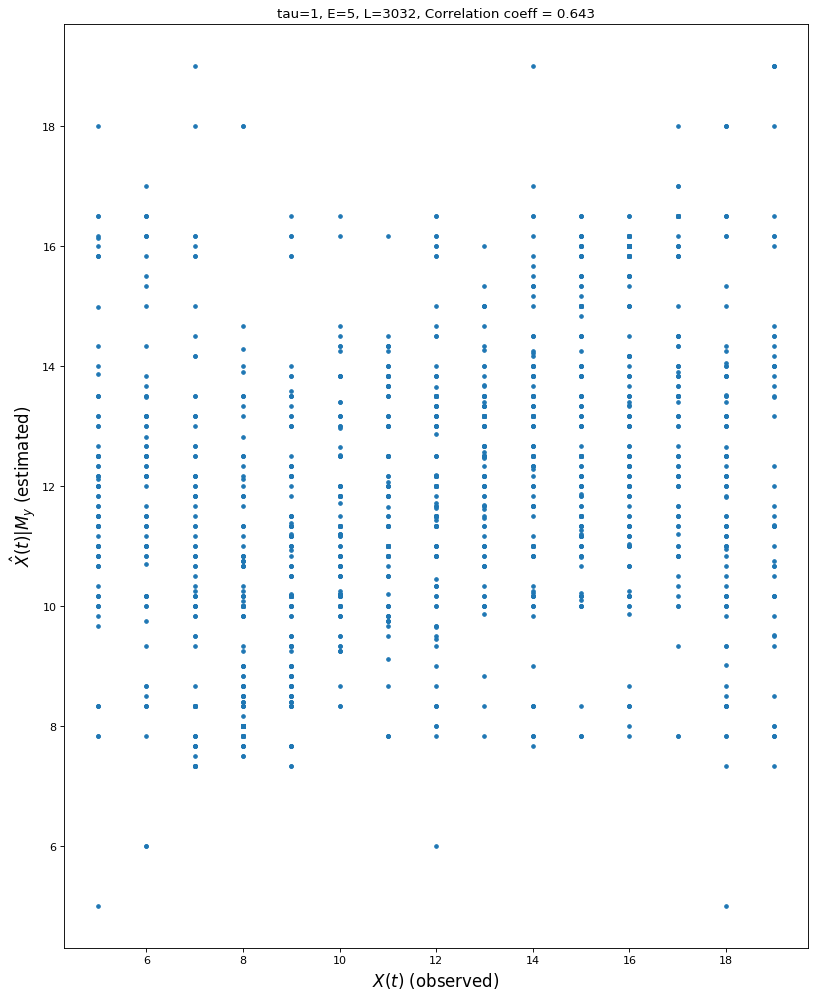

Statistics value = 2959943.0 p-value = 3.5691580022230607e-45
x: ['correlation', 0.6177]
x: [('F-statistic', 31.336754267307086), ('F-p', 3.3423036817320136e-31), ('chi2', 157.25523071475226), ('chi-p', 3.80579568744725e-32)]
x: [('ccm_score', 0.643), ('ccm_pval', 0.0)]
x: [('arima_pval', 3.5691580022230607e-45), ('arima_stat', 2959943.0), ('arima_cohen', 0.05022458872897109)]


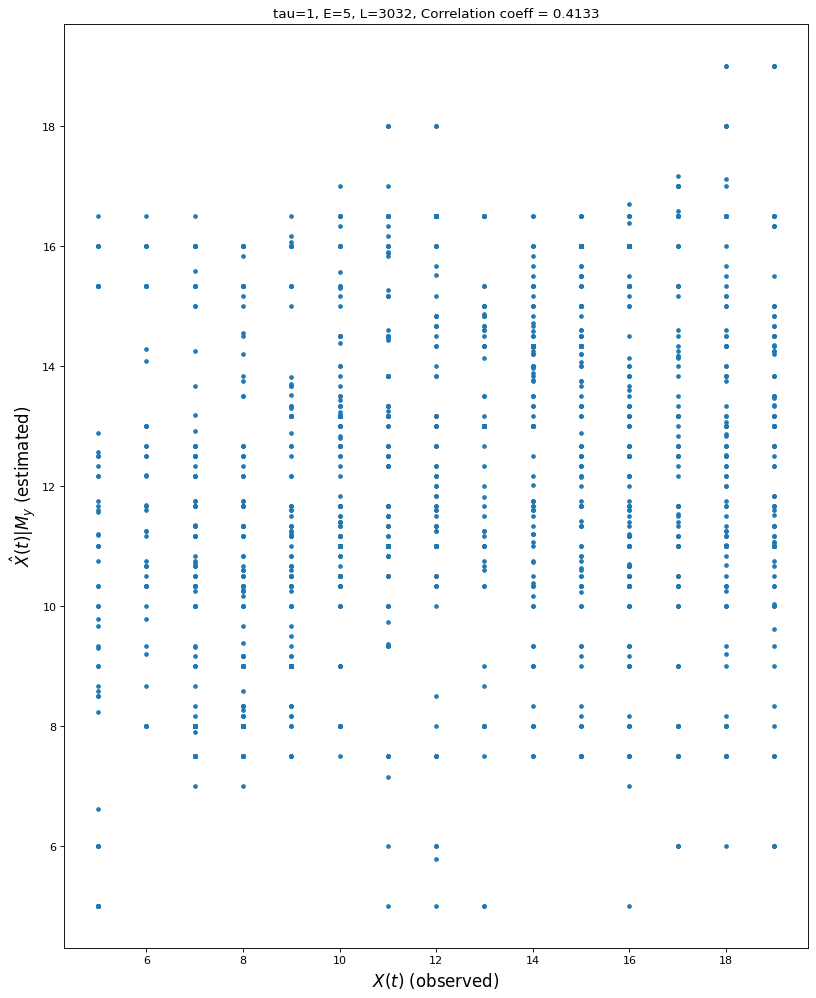

Statistics value = 702272.0 p-value = 1.0
y: ['correlation', 0.3322]
y: [('F-statistic', 4.461709504594234), ('F-p', 0.0004718683902672143), ('chi2', 22.389911588870604), ('chi-p', 0.0004413610110633526)]
y: [('ccm_score', 0.4133), ('ccm_pval', 0.0)]
y: [('arima_pval', 1.0), ('arima_stat', 702272.0), ('arima_cohen', 0.05213364223539081)]
Causal Analysis for X = predator_1, Y = predator_0, 3032 data points.


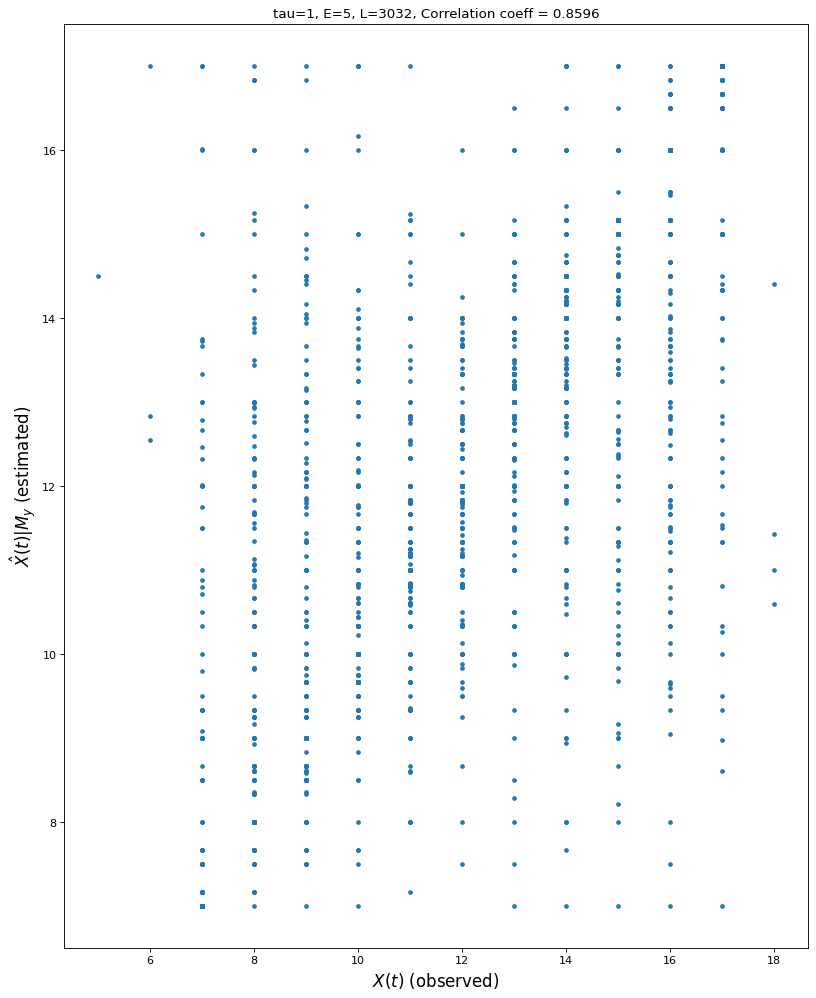

Statistics value = 2582890.0 p-value = 2.842717666529979e-10
x: ['correlation', 0.6177]
x: [('F-statistic', 3.671179180968258), ('F-p', 0.0025826666914067573), ('chi2', 18.422843801045953), ('chi-p', 0.002460586073778652)]
x: [('ccm_score', 0.8596), ('ccm_pval', 0.0)]
x: [('arima_pval', 2.842717666529979e-10), ('arima_stat', 2582890.0), ('arima_cohen', 0.01625697367078478)]


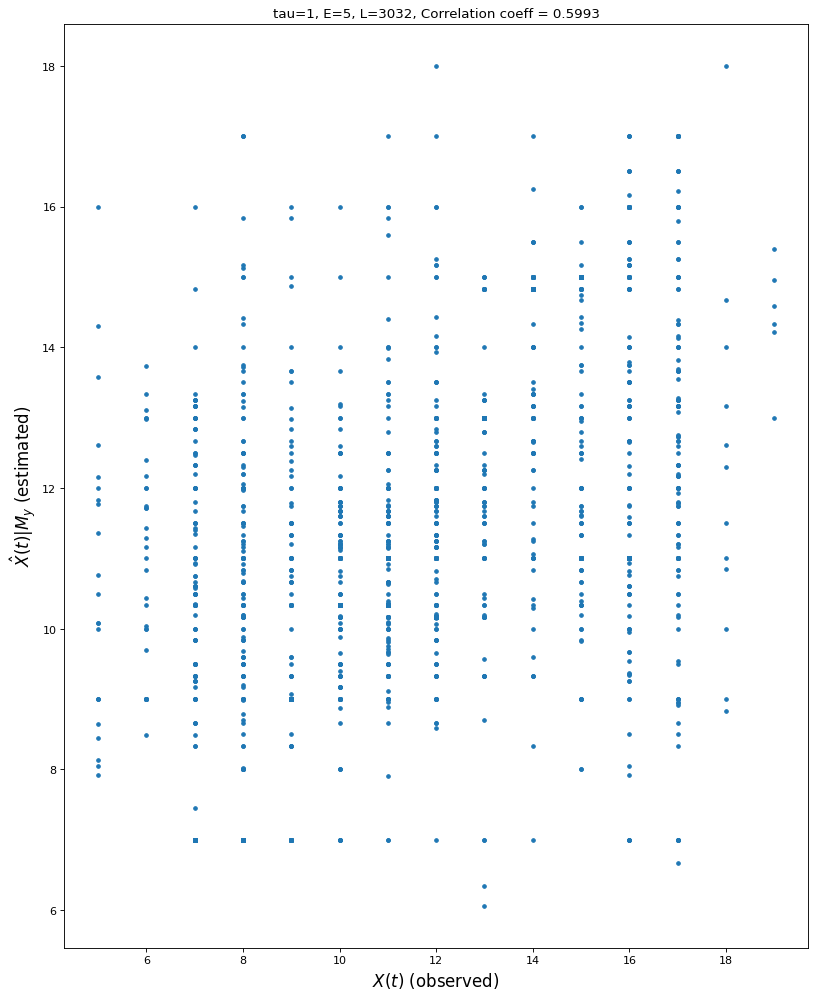

KeyboardInterrupt: 

In [165]:
dimensions = ['x', 'y']
print(f"Policy Mapping Fn: {policy_map}")
for pair in CAUSAL_PAIRS:
    print(f"Causal Analysis for X = {pair[0]}, Y = {pair[-1]}, {len(collected_data)} data points.")
    for dim in dimensions:
        X: pd.Series = collected_data.loc[:, f"{pair[0]}_{dim}"]
        Y: pd.Series = collected_data.loc[:, f"{pair[1]}_{dim}"]
        results = list()
        
        results.append(get_correlation(X, Y))
        results.append(get_granger_linear(X, Y, 5))
        results.append(get_ccm(X, Y, 5))
        results.append(get_granger_arima(X, Y, 5))
        for result in results:
            print(f"{dim}: {result}")

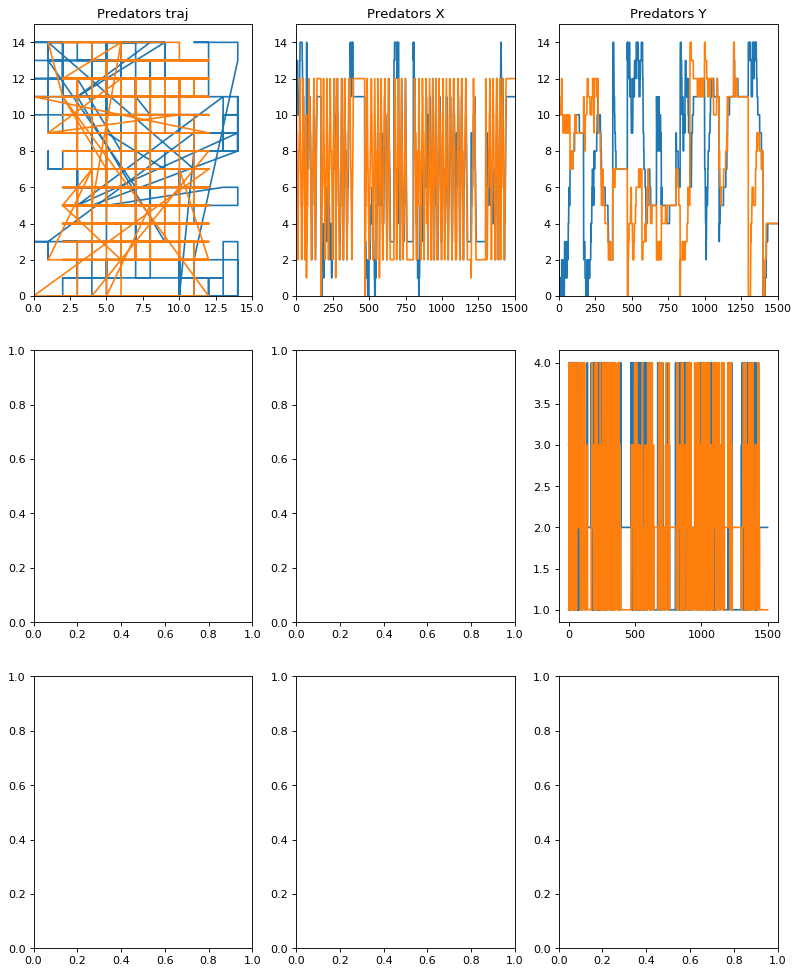

In [158]:
plt.rcParams.update({'figure.figsize':(12, 15), 'figure.dpi':80})
L = 1500
df = collected_data[-L:].copy()
# Original Series
fig, axes = plt.subplots(3, 3)
axes[0, 0].set_xlim([0, env_config["map_size"]]); axes[0, 0].set_ylim([0, env_config["map_size"]])
axes[0, 1].set_xlim([0, L]); axes[0, 1].set_ylim([0, env_config["map_size"]])
axes[0, 2].set_xlim([0, L]); axes[0, 2].set_ylim([0, env_config["map_size"]])
pad = env.pred_vision + 1
axes[0, 0].plot(df.predator_0_x-pad, df.predator_0_y-pad); axes[0, 0].set_title('Predators traj')
axes[0, 0].plot(df.predator_1_x-pad, df.predator_1_y-pad); axes[0, 0]
axes[0, 1].plot(np.arange(0, L), df.predator_0_x-pad); axes[0, 1].set_title('Predators X')
axes[0, 1].plot(np.arange(0, L), df.predator_1_x-pad)
axes[0, 2].plot(np.arange(0, L), df.predator_0_y-pad); axes[0, 2].set_title('Predators Y')
axes[0, 2].plot(np.arange(0, L), df.predator_1_y-pad)
axes[1, 2].plot(np.arange(0, L), df.predator_0_action); axes[0, 2].set_title('Predators Y')
axes[1, 2].plot(np.arange(0, L), df.predator_1_action)
# axes[0, 0].plot(df.index, df.predator_0_y); axes[0, 0].set_title('Predator 0 Y')
plt.show()

In [34]:
num_points

100

In [19]:
df

,predator_0_x,predator_0_y,predator_0_action,predator_0_dx,predator_0_dy,predator_0_PCA_1,predator_0_PCA_2,predator_1_x,predator_1_y,predator_1_action,predator_1_dx,predator_1_dy,predator_1_PCA_1,predator_1_PCA_2
0,10,4,1,1.0,0.0,-0.482183,-0.434613,16,14,4,0.0,1.0,1.872864,2.213138
1,9,4,4,0.0,1.0,-1.065425,-1.140806,16,13,3,0.0,-1.0,2.837883,2.852343
2,9,3,4,0.0,0.0,-1.877723,-1.951998,16,14,2,-1.0,0.0,1.872864,1.614442
3,9,3,1,1.0,0.0,-1.877723,-1.829150,17,14,3,0.0,-1.0,2.135042,2.085571
4,8,3,2,-1.0,0.0,-2.460965,-2.453444,17,15,3,0.0,-1.0,1.170023,1.147017
5,9,3,2,-1.0,0.0,-1.877723,-1.870099,17,16,1,1.0,0.0,0.205003,-0.390231
6,10,3,1,1.0,0.0,-1.294481,-1.245805,16,16,3,0.0,-1.0,-0.057175,0.036683
7,9,3,2,-1.0,0.0,-1.877723,-1.870099,16,17,4,0.0,1.0,-1.022195,-0.602522
8,10,3,1,1.0,0.0,-1.294481,-1.245805,16,16,3,0.0,-1.0,-0.057175,0.036683
9,9,3,2,-1.0,0.0,-1.877723,-1.870099,16,17,2,-1.0,0.0,-1.022195,-1.201218


ARIMA modelling for the following data. Length = 100

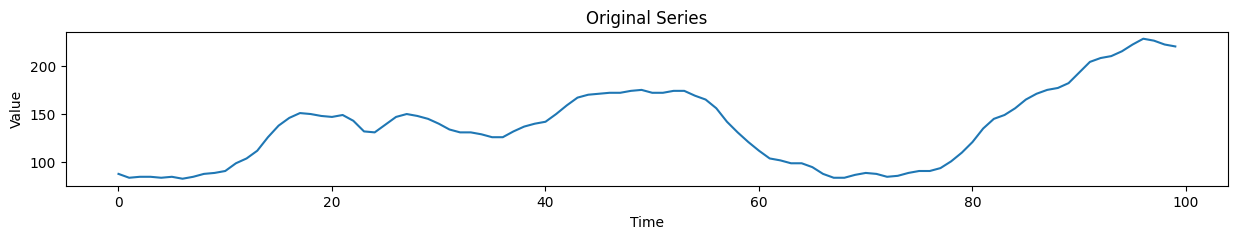

100

In [5]:
# X and Y, Linear and Independent 
df = read_csv('wwwusage.csv', names=['value'], header=0)
plt.figure(figsize=(15, 2))
plt.plot(df)
plt.title('Original Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()
len(df)

STEP 1: Make sure the data is stationary. 

A. Conduct a ADF Statistic test; null hypothesis data is not stationary; only p < 0.05 indicates stationary (small is good).

If not stationary under the ADF test, perform differncing and test again. Repeat.

The Graph of the right shows the at what order to lag does the autocorrelation test reveals no coorelation between data. We see that the second order diff results in a plot that is safe. 


ADF Statistic: -2.464240
p-value: 0.124419


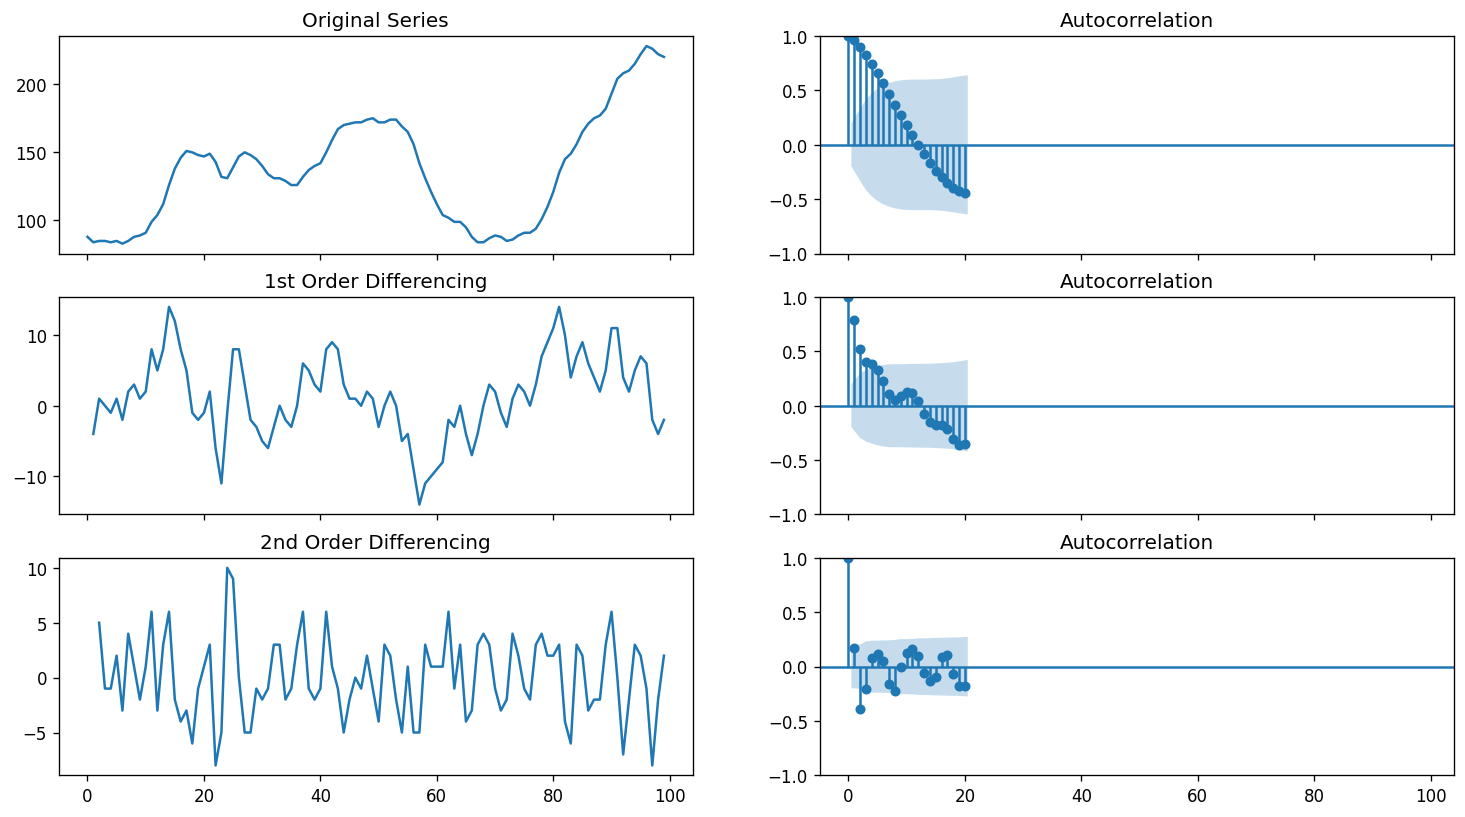

ADF Statistic for 1st Order Differencing
ADF Statistic: -2.722238
p-value: 0.070268
Critical Values:
	1%: -3.500
	5%: -2.892
	10%: -2.583

 ADF Statistic for 2nd Order Differencing
ADF Statistic: -9.929762
p-value: 0.000000
Critical Values:
	1%: -3.500
	5%: -2.892
	10%: -2.583


In [9]:
result = adfuller(df)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

plt.rcParams.update({'figure.figsize':(15,8), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.value); axes[0, 0].set_title('Original Series')
plot_acf(df.value, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.value.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.value.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.value.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

print('ADF Statistic for 1st Order Differencing')
result = adfuller(df.value.diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

print('\n ADF Statistic for 2nd Order Differencing')
result = adfuller(df.value.diff().diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

In order to build a ARIMA model the lag 'p', order of diff 'd' and the lag for MA (residuals) 'q' must be found. 

d = 1 has been chosen from above. 

1. To find the variable 'p', PCAF (partial autocorrelation test) to test signifact number of lag terms to include. 

2. Simillar to how we determined p, we will now look at the ACF to determine the q terms to be considered for our MA. The ACF tells how many MA terms are required to remove any autocorrelation in the stationary series.

In [ ]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(15,2.5), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.value.diff().dropna(), ax=axes[1])

plt.show()

In [ ]:
# ACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(15,4), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1))
plot_acf(df.value.diff().dropna(), ax=axes[1])

plt.show()

In [13]:
from statsmodels.tsa.arima.model import ARIMA 
model = ARIMA(df.value, order=(2,1,3))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  100
Model:                 ARIMA(2, 1, 3)   Log Likelihood                -251.887
Date:                Tue, 23 Jan 2024   AIC                            515.774
Time:                        19:35:41   BIC                            531.345
Sample:                             0   HQIC                           522.074
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5641      0.505      1.118      0.264      -0.425       1.553
ar.L2          0.2410      0.345      0.698      0.485      -0.435       0.917
ma.L1          0.6227      0.504      1.236      0.2